In [1]:
### LIBRARIES / HEADER STUFF {
import json                  # Initial dataset import
from graphviz import Digraph # Primary renderer
### }

In [22]:
### Hyperparams {
REMOVEGRADCLASS = True
REQUIREMENTCOLOR = False
REQUIRED = {'PHYS039','MATH009A','MATH009B','MATH009C','CHEM001A',
            'CHEM001B','CHEM001C','CS010','MATH010A','MATH010B','MATH046',
            'PHYS041A','PHYS041B','PHYS041C','PHYS130A','PHYS130B','PHYS132',
            'PHYS135A','PHYS135B','PHYS156A','PHYS156B','PHYS139L','PHYS142W'}
REMOVENONMAJOR = False
DARKTHEME = True
DARKTHEMECOLORS = {'background':'#043742',
                   'boxes':'#6a8690',
                   'lines':'#3fc6b4',
                   'textcolor':'white'}
MAJOR = {'PHYS','CS','MATH'} # set for faster 'in' check
SPECIALFLAG = None # Can use 'all' to get a graph of every major
### }

In [23]:
### IMPORT FROM DATASET {

def importData(loc): # File location should have all_prereqs and subjects.json in it
    with open(loc + '/201740_all_prereqs.json','r') as f:
        data = json.load(f)

    # Define course object
    class course:
        def __init__(self, courseName, preReq, courseID, subject):
            self.courseName = courseName
            self.preReq = preReq
            self.courseID = courseID
            self.subject = subject

    # Mildly brittle parser
    def parseAndOr(testString):
        # Presumption: AND statements are top level, then there are OR statements.
        # So there's nothing like (CS 111 AND CS 11) OR (MATH 031 AND MATH 10A)
        # This is important because the parser 
        if testString == dict():
            return dict()
        if len(testString.split('\n')) < 3:
            return dict()
        if 'Score for' in testString: # EXTREMELY HACKY SOLUTION
            return dict()
        mod = testString.split('and\n')
        mod = [x.split('or\n') for x in mod]
        mod = [[y.split('\n') for y in x] for x in mod]

        # Now get all of the 'Computer Science': 'CS' type information
        with open(loc + '/subjects.json') as f:
            codes = json.load(f)
        lookup = {x['description']:x['code'] for x in codes}

        def classconvert(classname):
            intermed = classname.split(' ')
            intermed = [' '.join(intermed[:-1]), intermed[-1]]
            # lookup is defined above
            if intermed[0] in lookup:
                return lookup[intermed[0]] + intermed[1]
            else:
                return classname

        try:
            # This is the most horrific list comprehension I've every written, but it works
            mod = [[[
                 classconvert(y[1][y[1].index('Test:')+6:].strip()), # Class name
                 y[2].split(' ')[-1], # Grade
                 'NC' if y[3].strip()[:7] == 'May not' else 'C' # Concurrent allowed?
                    ] if y[0] == '(' else [
                 classconvert(y[0][y[0].index('Test:')+6:].strip()), # Class name
                 y[1].split(' ')[-1], # Grade
                 'NC' if y[2].strip()[:7] == 'May not' else 'C' # Concurrent allowed?
                    ] for y in x] for x in mod]
        except:
            print(testString)
            print(mod)
            raise
        return mod

    courseList = []
    for currentCourse in data:
        try: # Dealing with situations where prereq didn't get written
            mycourse = course(currentCourse['subjectCourse'], parseAndOr(currentCourse['prereqs']), currentCourse['id'], currentCourse['subject'])
        except KeyError:
            mycourse = course(currentCourse['subjectCourse'], dict(), currentCourse['id'], currentCourse['subject'])
        courseList.append(mycourse) # Writes course objects to a list
    
    return courseList

courseList = importData('/home/order/Dropbox/Python_Code/Cloned/ucr-course-graph/data')

### }

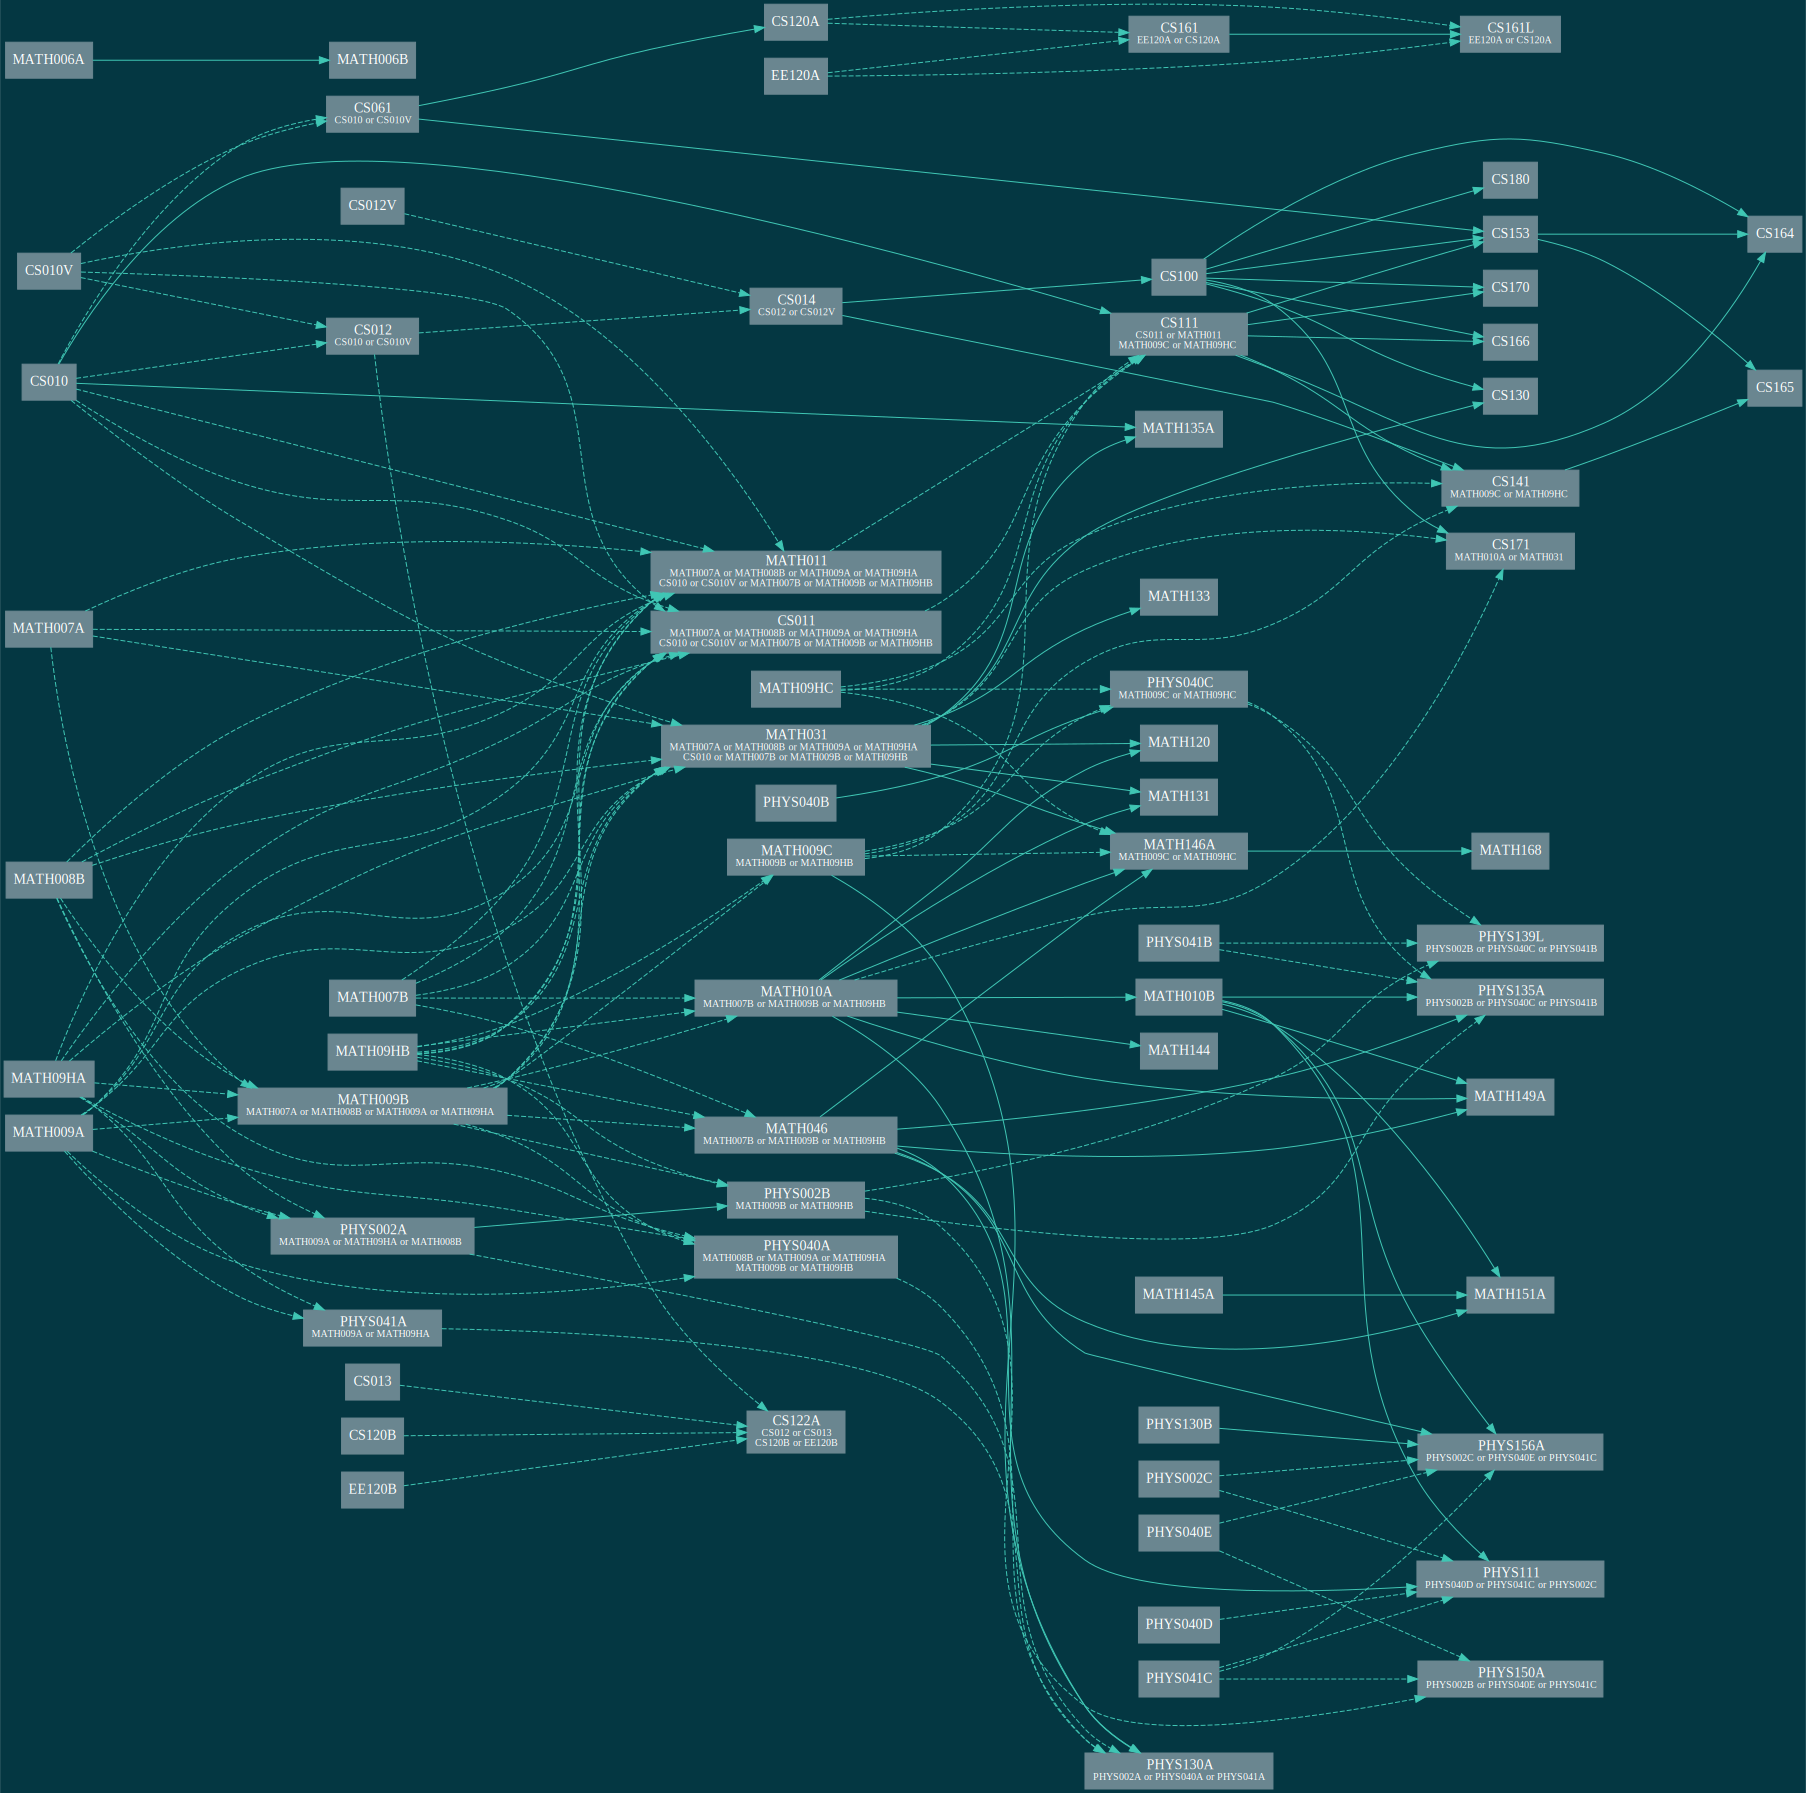

In [24]:
### RENDER GRAPH {

def constructGraph(courseList):
    def undergradOnly(courseList):
        numbers = set('0123456789')
        return [x for x in courseList if [y for y in x.courseName if y in numbers][0] in {'0','1'}]

    def selectMajor(courseList,major,flag=None):
        # Use 4-code for major (eg 'PHYS')
        if flag == 'all':
            return [x for x in courseList if x.subject not in {'TFDP','PSYC'}] # These two have errors of some sort
        else:
            return [x for x in courseList if x.subject in major]

    if REMOVEGRADCLASS:
        majorList = undergradOnly(selectMajor(courseList, MAJOR, flag=SPECIALFLAG))
    else:
        majorList = selectMajor(courseList, MAJOR, flag=SPECIALFLAG)

    if DARKTHEME:
        dot = Digraph(comment='classflow test',graph_attr={'rankdir': 'LR', 'ranksep': '2', 'overlap': 'false', 'bgcolor':DARKTHEMECOLORS['background']})
    else:
        dot = Digraph(comment='classflow test',graph_attr={'rankdir': 'LR', 'ranksep': '2', 'overlap': 'false'})

    # Robustly add new classes (on a new line) to the labels inside the nodes
    def safeAddLabel(course_name, new_prereq):
        # Check to see if the node already has a label
        dotline = [x for x in dot.__dict__['body'] if x.split(' ')[0][1:] == course_name and 'label=' in x]
        if dotline: # If non-empty, then node already has a label
            dotline = dotline[-1] # We want the most recent label written
            def addPrereqHTML(label,new_prereq):
                posn = label.index('</FONT')
                return label[:posn] + '<br />' + new_prereq + label[posn:]
            # I have literally no idea why the ']' bug happens; I think it's a dot issue
            newlabel = addPrereqHTML(dotline[dotline.index('label=')+6:] if dotline[-1] != ']' else dotline[dotline.index('label=')+6:-1],new_prereq)
            dot.node(course_name,label=newlabel)
        else: # No current label (or node doesn't exist), so initialize it
            dot.node(course_name,label='<' + course_name + '<br /><FONT POINT-SIZE="10">' + new_prereq +'</FONT>>')

    # Define how to draw between courses (with all the relevant conditions)
    def requisiteLine(fromCourse,toCourse,graph,fromOrGroup=False,**args):
        """fromCourse example: "['ANTH001', 'D-', 'NC']"
           toCourse example: "course" object with courseName, etc.
           Creates nodes on both ends, then draws the requisite line between the two of them.
           Also references the global REQUIRED list"""

        shape = 'box'

        ### ALTERNATE ROUTE: If one of the edges isn't a part of the major, instead make a label under the
        ### class pointed to, then ignore the edge initialization
        if REMOVENONMAJOR:
            # Uses same code as not REMOVENONMAJOR, but intelligently changes the iterator
            numbers = set('0123456789')
            for i,x in enumerate(fromCourse[0]):
                if x in numbers:
                    index = i
                    break
            subj = fromCourse[0][:index]
            iterator = [fromCourse[0],toCourse.courseName] if subj in MAJOR else [toCourse.courseName]
            # Create nodes
            if REQUIREMENTCOLOR:
                for toNode in iterator:
                    if toNode in REQUIRED:
                        graph.node(toNode,style='filled',color='gold',shape=shape)
                    else:
                        graph.node(toNode,style='filled',color='lightblue2',shape=shape)
            else:
                for toNode in iterator:
                    if DARKTHEME:
                        graph.node(toNode,shape=shape,style='filled',color=DARKTHEMECOLORS['boxes'],fontcolor=DARKTHEMECOLORS['textcolor'])
                    else:
                        graph.node(toNode,shape=shape)

            # Since edge auto-creates nodes, now only run if len(iterator) == 2.
            if len(iterator) == 2:
                if DARKTHEME:
                    graph.edge(fromCourse[0],toCourse.courseName,color=DARKTHEMECOLORS['lines'],**args)
                else:
                    graph.edge(fromCourse[0],toCourse.courseName,color='black',**args)
            else: # If not, add a label for the missing class (unless already written as a part of the orGroup)
                if not fromOrGroup:
                    safeAddLabel(toCourse.courseName,fromCourse[0])

        else:
            # Create nodes
            if REQUIREMENTCOLOR:
                for toNode in [fromCourse[0],toCourse.courseName]:
                    if toNode in REQUIRED:
                        graph.node(toNode,style='filled',color='gold',shape=shape)
                    else:
                        graph.node(toNode,style='filled',color='lightblue2',shape=shape)
            else:
                for toNode in [fromCourse[0],toCourse.courseName]:
                    if DARKTHEME:
                        graph.node(toNode,shape=shape,style='filled',color=DARKTHEMECOLORS['boxes'],fontcolor=DARKTHEMECOLORS['textcolor'])
                    else:
                        graph.node(toNode,shape=shape)
            # Draw line
            if DARKTHEME:
                graph.edge(fromCourse[0],toCourse.courseName,color=DARKTHEMECOLORS['lines'],**args)
            else:
                graph.edge(fromCourse[0],toCourse.courseName,color='black',**args)

    # Create lines between courses
    runID = 0
    for _class in majorList:
        if _class.preReq != dict():
            # _class.preReq is an "and_group"
            for orGroup in _class.preReq:
                if len(orGroup) > 1:
                    for _prereq in orGroup:
                        requisiteLine(_prereq,_class,dot,style='dashed', fromOrGroup=True)
                    # Now add the or group as a prereq under the node
                    # Be careful to not overwrite other labels; automatically do a <BR /> if needed.
                    safeAddLabel(_class.courseName,' or '.join([x[0] for x in orGroup]))
                else:
                    requisiteLine(orGroup[0],_class,dot)
    return dot

dot = constructGraph(courseList)
# dot.node('PHYS111',label='PHYS111')
# safeAddLabel()
dot

In [25]:
dot.render(filename='./test',view=True,format='png')

'./test.png'

In [22]:
with open('/home/order/Dropbox/Python_Code/Cloned/ucr-course-graph/data/subjects.json') as f:
    codes = json.load(f)
lookup = {x['description']:x['code'] for x in codes}
print(lookup)

{'Academic Resource Center': 'ARC', 'Anthropology': 'ANTH', 'Arabic Language': 'ARBC', 'Art': 'ART', 'Art History': 'AHS', 'Asian Studies': 'AST', 'Basic Writing': 'BSWT', 'Biochemistry': 'BCH', 'Bioengineering': 'BIEN', 'Biology': 'BIOL', 'Biomedical Sciences': 'BMSC', 'Botany/Plant Science': 'BPSC', 'Business': 'BUS', 'CHASS First Yr Experience Prog': 'CHFY', 'Cell Biology and Neuroscience': 'CBNS', 'Cell, Molecular, and Develpmnt': 'CMDB', 'Chemical Engineering': 'CHE', 'Chemical and Environmental Eng': 'CEE', 'Chemistry': 'CHEM', 'Chinese': 'CHN', 'Classical Studies': 'CLA', 'Comparative Ancient Civilizatn': 'CPAC', 'Comparative Literature': 'CPLT', 'Computer Science': 'CS', 'Creative Writing': 'CRWT', 'Crwt Wrt &amp; Wrt for Perf Arts': 'CWPA', 'Dance': 'DNCE', 'Economics': 'ECON', 'Education': 'EDUC', 'Electrical Engineering': 'EE', 'Engineering': 'ENGR', 'English': 'ENGL', 'Entomology': 'ENTM', 'Environmental Engineering': 'ENVE', 'Environmental Sciences': 'ENSC', 'Environmental